In [44]:
import sys
import serial
import signal
#import random
from threading import Thread
from IPython import display
import seaborn as sns
from pylab import *
import time

In [2]:
def get_input(channel):
    return received[channel].averaged_value()

def signal_handler(signal, frame):
    ser.close()
    print( 'closed port. exit.' )
    sys.exit(0)

def init_serial():
    ser = serial.Serial(port = PORT, baudrate = BAUD_RATE)
    signal.signal(signal.SIGINT, signal_handler)
    return ser

PORT = '/dev/ttyACM3'
BAUD_RATE = 9600
NUM_CHANNELS = 6

WIDTH, HEIGHT = 800, 600
SIZE = (WIDTH, HEIGHT)
BLACK = (0,0,0)
RED = (255,0,0)

ser = init_serial()
#serial_thread = Thread(target=receive_data)
#serial_thread.daemon = True
#serial_thread.start()

In [4]:
def receiving(ser):
    global last_received
    buffer = ''

    while True:
        buffer += ser.read(ser.inWaiting()).decode("utf-8")
        if '\n' in buffer:
            last_received, buffer = buffer.split('\n')[-2:]

t = Thread(target=receiving, args=(ser,))
t.start()

In [ ]:
import time
data = []

for i in range(1000):
    data += last_received
    time.sleep(0.01)

In [46]:
def serial_input(timeout=1000):
    global last_received
    try:
        #ser.reset_input_buffer()
        rec = last_received
        index = 0
        data = [int(i) for i in rec.split(';')[:-1]]
        #print(data)

        #mins = data[::3]
        #maxs = data[2::3]
        #vals = data[1::3]
        mins = []
        maxs = []
        vals = data
        return mins, maxs, vals
    except:
        return [], [], []

_,_,vals = serial_input()

print(vals)

[510, 555, 566, 587, 602, 571]


In [196]:
def get_data():
    vals = []
    while not (len(vals) == 6):
        _,_,vals = serial_input()
    
    return range(6), np.array(vals) / 1023.
get_data()

(range(0, 6),
 array([ 0.5542522 ,  0.55327468,  0.56891496,  0.57478006,  0.59824047,
         0.57771261]))

KeyboardInterrupt: 

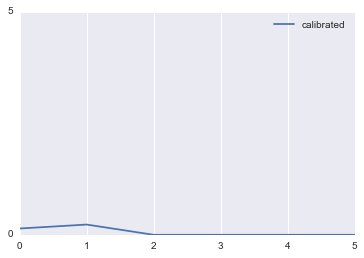

In [238]:
%matplotlib inline

x = []
y = []

mins = np.zeros((6,)) + 1000
maxs = np.zeros((6,)) + 0.01

for i in range(1000):
    x, y = get_data()
    #y -= offset
    #mins = np.minimum(y, mins)
    #maxs = np.maximum(y, maxs)
    #y = (y - mins) / (maxs - mins)
    yc = convert_signal(y)

    plt.gca().cla() 
    #plt.plot(x,y[::-1]*10,label='original',marker="x")
    plt.plot(x,yc[::-1],label='calibrated',marker="x")
    plt.legend()
    plt.xticks(x)
    plt.yticks([0,5])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #time.sleep(0.5)
        

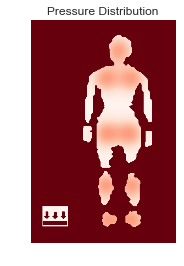

In [249]:
from skimage.io import imread
from bokeh.charts import HeatMap, output_notebook
from skimage.filters import gaussian
import numpy as np
import seaborn as sns
from pylab import *
%matplotlib inline

def plot_heatmap(pressure_vals, sigma=25., shape=(568,367)):
    heatmap = zeros(shape)
    
    # map sensor to position in the heatmap
    positions = {"head" : (221,79),
                 "shoulder_left":(189,150),
                 "shoulder_right":(255,150),
                 "bottom_left" : (190,290),
                 "bottom_right" : (250,290),
                 "leg_left" : (188,421),
                 "leg_right" : (256,421),
                 "foot_left" : (194,509),
                 "foot_right" : (256, 509)
                }
    
    sensor2pos = {0 : ("head",),
                  1: ("shoulder_left", "shoulder_right"),
                  2: ("bottom_left","bottom_right"),
                  3: ("leg_left", "leg_right"),
                  4: ("foot_left", "foot_right"),
                  5: (),
                 }
    
    for i in sensor2pos.keys():
        for sensor in sensor2pos[i]:
            p = positions[sensor]
            newpos = zeros((568,367))
            newpos[p[1], p[0]] = 1
            heatmap_addition = gaussian(newpos, sigma)
            heatmap += heatmap_addition / heatmap_addition.max() * pressure_vals[i]
            
    return heatmap

img = (imread("body.png"))
img[img < 0.25] = 0
img[img > 0.75] = 1
img[(img > 0.25) & (img < 0.75)] = 0.5

def show_pressuremap(plt,yy=0.4*np.ones(6,)):
    global img
    
    img_cp = img.copy()
    
    heat = 0.8 * (plot_heatmap(yy))
    img_cp[img == 0.5] = heat[img == 0.5]
    plt.imshow(img_cp, cmap="Reds")
    plt.axis("off")
    plt.title("Pressure Distribution")
    
show_pressuremap(plt)

KeyboardInterrupt: 

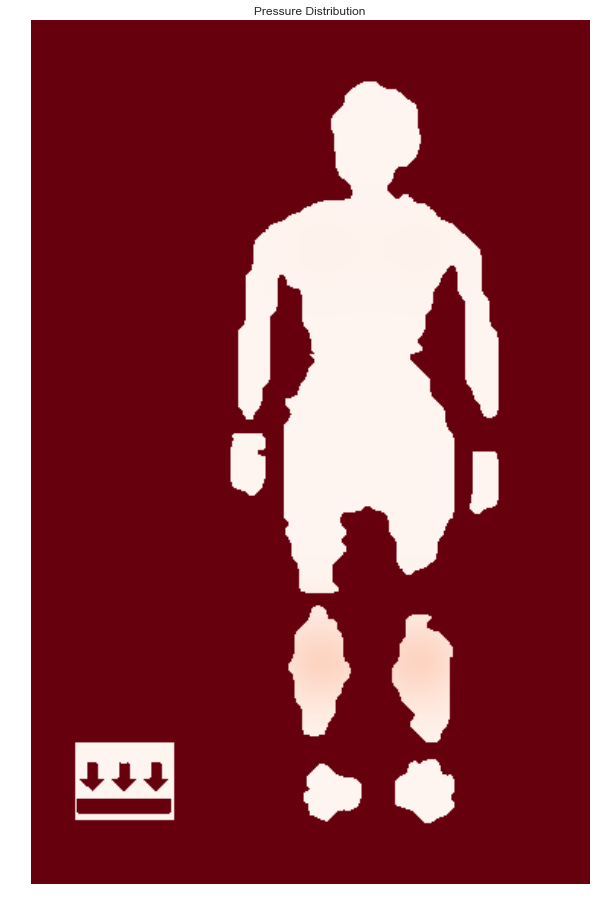

In [253]:
%matplotlib inline

figure(figsize=(10,30))
for i in range(1000):
    x, y = get_data()
    yc = convert_signal(y)
    plt.gca().cla() 
    show_pressuremap(plt, yy=yc / 5.)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    display.display(yc)
    #time.sleep(0.5)

In [213]:
from skimage.io import imread

img = imread("body.png")

In [100]:
# First step: Zero Point calculation

for i in range(300):
    x, y = get_data()
    data[0,i,:] = y
    time.sleep(0.01)

In [55]:
# First step: Zero Point calculation

nb_samples = 300
data = zeros((6, nb_samples, 6))
kgs = [1, 2, 3, 4, 5]

for kg in kgs:
    input("Next weight: " + str(kg) + "kg")
    for j in range(6):
        input("Next sensor: " + str(j+1))
        for i in range(nb_samples):
            x, y = get_data()
            data[kg, i, j] = y[j]
            time.sleep(0.01)


history = np.array(data)
plot(history)

#offsets = history.mean(axis=0)
#print (offsets)

Next weight: 1kg
Next sensor: 1
Next sensor: 2
Next sensor: 3
Next sensor: 4
Next sensor: 5
Next sensor: 6
Next weight: 2kg
Next sensor: 1
Next sensor: 2
Next sensor: 3
Next sensor: 4
Next sensor: 5
Next sensor: 6
Next weight: 3kg
Next sensor: 1
Next sensor: 2
Next sensor: 3
Next sensor: 4
Next sensor: 5
Next sensor: 6
Next weight: 4kg
Next sensor: 1
Next sensor: 2
Next sensor: 3
Next sensor: 4
Next sensor: 5
Next sensor: 6
Next weight: 5kg
Next sensor: 1
Next sensor: 2
Next sensor: 3
Next sensor: 4
Next sensor: 5
Next sensor: 6


ValueError: x and y can be no greater than 2-D

In [101]:
np.savez("calib-3", data)

In [ ]:
npzfile = np.load("calib.gz.npz")
data = npzfile['arr_0']

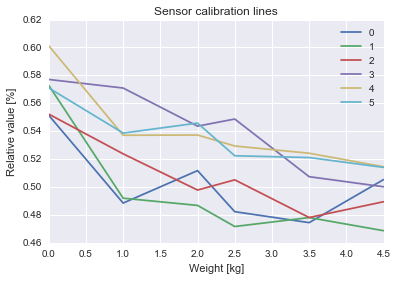

[[ 0.00022601  0.00021077  0.00026519  0.00047214  0.00021026  0.00039472]
 [ 0.00047403  0.00078046  0.00204917  0.00355266  0.00129507  0.00153727]
 [ 0.00182953  0.00262288  0.00212796  0.00268796  0.00393175  0.00137433]
 [ 0.00060697  0.00065571  0.00413855  0.0087189   0.00173661  0.00206568]
 [ 0.00085652  0.00074499  0.00349898  0.00404962  0.00076677  0.00098649]
 [ 0.00035603  0.00073419  0.0013681   0.00296506  0.00056433  0.00096365]]


In [102]:
means = data.mean(axis=1)
stds = data.std(axis=1)

for i in range(6):
    plot([0,1,2,2.5,3.5,4.5],means[:,i], label=str(i))
legend()
xlabel("Weight [kg]")
ylabel("Relative value [%]")
title("Sensor calibration lines")
show()
print(stds)

In [254]:
df = pd.DataFrame()
weights = np.repeat([0,1,2,2.5,3.5,4.5], data.shape[1])
datapoints = data.reshape((-1, 6))

df = pd.DataFrame(datapoints)
df["weights"] = weights
df = df.set_index("weights")

colors = ["b", "g", "r", "c", "y", "k"]

pressure_fn = []
for i in range(6):
    fit = np.polyfit(df.index,df[i],3)
    fit_fn = np.poly1d(fit) 
    
    pressure_fn.append(np.poly1d(np.polyfit(df[i], df.index, 2)))
    
    #plot(df.index,df[i], colors[i] + "o", df.index,fit_fn(df.index), colors[i] + "-")
    xx = np.linspace(0.46, 0.62, 100)
    plot(df[i],df.index, colors[i] + "o", xx, pressure_fn[i](xx), colors[i] + "-", label = str(i))
    show()
#show()

AttributeError: 'dict' object has no attribute 'shape'

In [205]:
def convert_signal(y):
    return np.array([pressure_fn[i](y[i]) for i in range(y.shape[0])]).clip(0, 10)

convert_signal(np.arange(6))

array([  0.,  10.,  10.,   0.,  10.,  10.])

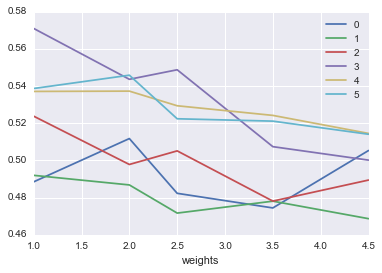

In [96]:
import pandas as pd

%matplotlib inline

y = means[1:,:]
df = pd.DataFrame(y)
df["weights"] = [1,2,2.5,3.5,4.5]
df = df.set_index("weights")
df

df.plot()

show()

In [257]:
#ser.close()
t.is_alive()

False